In [ ]:
%pip install tensorflow


In [ ]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS , 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
draw_landmarks(frame, results)

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [ ]:
len(results.face_landmarks.landmark)

In [ ]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [6]:
def extract_keypoints(res):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]) 

In [ ]:
result_test = extract_keypoints(results)
result_test.shape

In [ ]:
np.save('0', result_test)

In [ ]:
np.load('0.npy')

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['A', 'B', 'C', 'apa', 'bagaimana', 'bermain', 'datang', 'kapan', 'kenapa', 'siapa']) #siapa, nama, kamu, aku, bermain 

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [8]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [ ]:
'''
for action in actions: 
    dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
        except:
            pass
'''

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(5000) # <--- Ini adalah timer sleep yang mengatur delay 2000 ms (2 detik)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [10]:
label_map = {label:num for num, label in enumerate(actions)}

In [11]:
label_map

{'A': 0,
 'B': 1,
 'C': 2,
 'apa': 3,
 'bagaimana': 4,
 'bermain': 5,
 'datang': 6,
 'kapan': 7,
 'kenapa': 8,
 'siapa': 9}

In [12]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [13]:
tf.random.set_seed(42)

In [14]:
X = np.array(sequences)

In [15]:
y = to_categorical(labels).astype(int)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
y_test.shape

(15, 10)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.callbacks import TensorBoard

In [18]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [36]:
'''
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
'''
'''
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30, X.shape[2])))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
'''

'''
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30, X.shape[2])))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(actions.shape[0], activation='softmax'))
'''

#AKURASI = 86.7%
model = Sequential()
# Menambah lapisan konvolusi pertama dengan lebih banyak filter
model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(30, X.shape[2])))
model.add(MaxPooling1D(pool_size=2))

# Bidirectional LSTM pertama dengan ukuran yang lebih besar
model.add(Bidirectional(LSTM(256, return_sequences=True, activation='relu')))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Menambah lapisan LSTM tambahan
model.add(Bidirectional(LSTM(512, return_sequences=True, activation='relu')))
model.add(Dropout(0.3)) 
model.add(BatchNormalization())

# LSTM terakhir dengan ukuran yang lebih besar
model.add(Bidirectional(LSTM(256, activation='relu')))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Menambah lapisan Dense sebelum output layer untuk meningkatkan kompleksitas
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

# Ubah output layer untuk 10 kelas
model.add(Dense(10, activation='softmax'))  # Jumlah kelas = 10

'''
# pake ini malah turun akurasinya = 60%
model = Sequential()
# Lapisan konvolusi dengan lebih banyak filter dan kedalaman
model.add(Conv1D(128, kernel_size=5, activation='relu', input_shape=(30, X.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Bidirectional LSTM dengan konfigurasi yang lebih kompleks
model.add(Bidirectional(LSTM(512, return_sequences=True, activation='relu')))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(768, return_sequences=True, activation='relu')))
model.add(Dropout(0.4)) 
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(512, activation='relu')))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Tambahkan lapisan Dense untuk meningkatkan kompleksitas
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output layer untuk 10 gestures
model.add(Dense(10, activation='softmax'))
'''

C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 26, 128)             │       1,063,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 11, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 5, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 5, 1024)             │       3,149,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 5, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 5, 1024)             │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 5, 1536)             │      11,016,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 5, 1536)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 1536)             │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 1024)                │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,394,122 (93.06 MB)

 Trainable params: 24,386,954 (93.03 MB)

 Non-trainable params: 7,168 (28.00 KB)

In [38]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [39]:
model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback]) #paling optimal di epoch = 500

Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 611ms/step - categorical_accuracy: 0.1442 - loss: 2.8928
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 607ms/step - categorical_accuracy: 0.1712 - loss: 2.4733
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 591ms/step - categorical_accuracy: 0.3951 - loss: 1.8437
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 592ms/step - categorical_accuracy: 0.4408 - loss: 1.5136
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 594ms/step - categorical_accuracy: 0.5364 - loss: 1.2384
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 592ms/step - categorical_accuracy: 0.6494 - loss: 1.0706
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 589ms/step - categorical_accuracy: 0.6608 - loss: 0.9281
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 587ms/step - categorical_accuracy: 0.6414 - loss: 0.8772
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 585ms/step - categorical_accuracy: 0.6673 - loss: 0.9375
Epoch 10/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 586ms/step - categorical_accuracy: 0.6976 - loss: 0.7822
Epoch 11/500
9/9 ━━━━━━━━━━━

In [40]:
res = model.predict(X_test)
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1.13471348e-08, 9.33440134e-08, 1.84464923e-07, 4.66500590e-13,
        1.48481893e-09, 2.11655293e-09, 9.99995589e-01, 3.37531567e-08,
        1.59895137e-08, 4.00408044e-06],
       [5.65644959e-03, 8.29295516e-01, 3.52267921e-03, 4.18617041e-04,
        2.15010047e-02, 4.60858308e-02, 6.24926873e-02, 1.89264619e-03,
        2.77323853e-02, 1.40213582e-03],
       [2.67070350e-12, 5.35709113e-08, 2.03000507e-12, 1.01631606e-07,
        4.87897118e-08, 6.25742860e-11, 8.14631473e-10, 2.96541685e-07,
        9.99987006e-01, 1.25442421e-05],
       [4.98752459e-04, 9.98351097e-01, 9.49636684e-04, 7.82134066e-07,
        1.73396402e-05, 9.29117377e-05, 5.56913765e-05, 3.66779773e-06,
        2.85183905e-05, 1.62096251e-06],
       [1.30518209e-04, 3.31629635e-05, 1.18847260e-04, 1.11988711e-05,
        4.70817881e-03, 5.87621616e-05, 6.88177301e-04, 9.87724543e-01,
        9.18438716e-04, 5.60815213e-03],
       [7.61517238e-10, 3.01311366e-06, 1.44986012e-09, 4.67183327e-06,
   

In [24]:
actions[np.argmax(res[0])]

'datang'

In [25]:
actions[np.argmax(y_test[0])]

'datang'

In [30]:
model.save('action.h5')

In [ ]:
del model

In [31]:
model.load_weights('action.h5')

In [41]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [42]:
yhat = model.predict(X_test)
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


array([[1.13471348e-08, 9.33440134e-08, 1.84464923e-07, 4.66500590e-13,
        1.48481893e-09, 2.11655293e-09, 9.99995589e-01, 3.37531567e-08,
        1.59895137e-08, 4.00408044e-06],
       [5.65644959e-03, 8.29295516e-01, 3.52267921e-03, 4.18617041e-04,
        2.15010047e-02, 4.60858308e-02, 6.24926873e-02, 1.89264619e-03,
        2.77323853e-02, 1.40213582e-03],
       [2.67070350e-12, 5.35709113e-08, 2.03000507e-12, 1.01631606e-07,
        4.87897118e-08, 6.25742860e-11, 8.14631473e-10, 2.96541685e-07,
        9.99987006e-01, 1.25442421e-05],
       [4.98752459e-04, 9.98351097e-01, 9.49636684e-04, 7.82134066e-07,
        1.73396402e-05, 9.29117377e-05, 5.56913765e-05, 3.66779773e-06,
        2.85183905e-05, 1.62096251e-06],
       [1.30518209e-04, 3.31629635e-05, 1.18847260e-04, 1.11988711e-05,
        4.70817881e-03, 5.87621616e-05, 6.88177301e-04, 9.87724543e-01,
        9.18438716e-04, 5.60815213e-03],
       [7.61517238e-10, 3.01311366e-06, 1.44986012e-09, 4.67183327e-06,
   

In [43]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [44]:
accuracy_score(ytrue, yhat)


0.6

In [30]:
mcm = multilabel_confusion_matrix(ytrue, yhat)

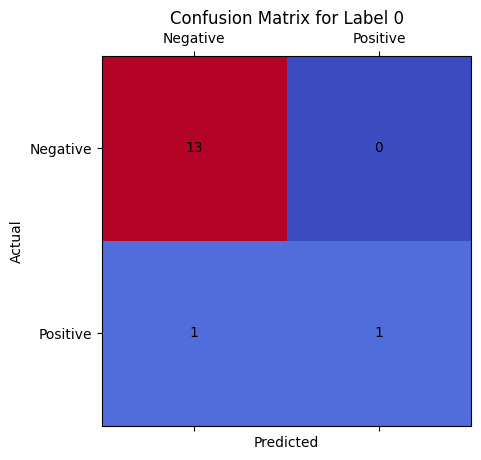

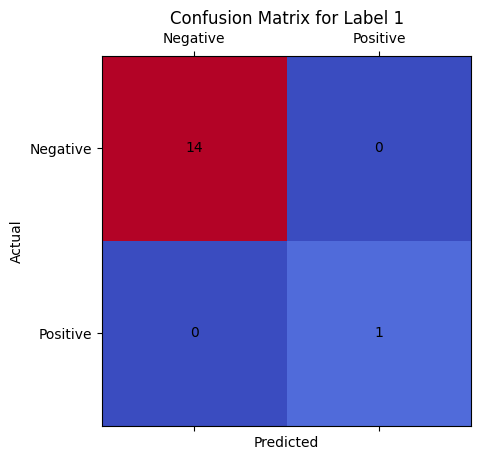

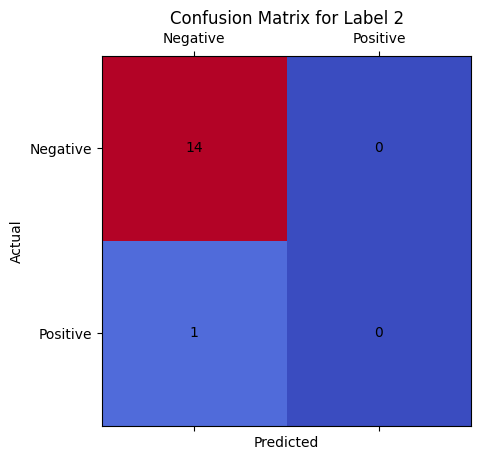

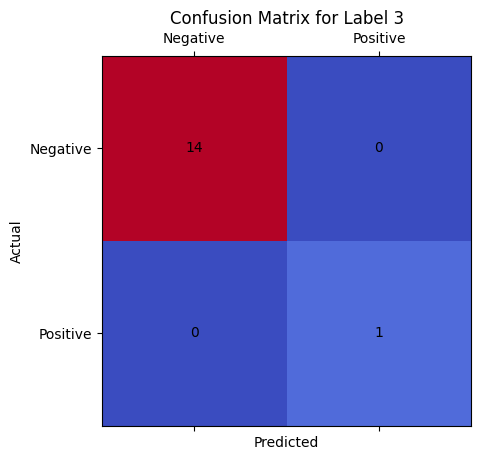

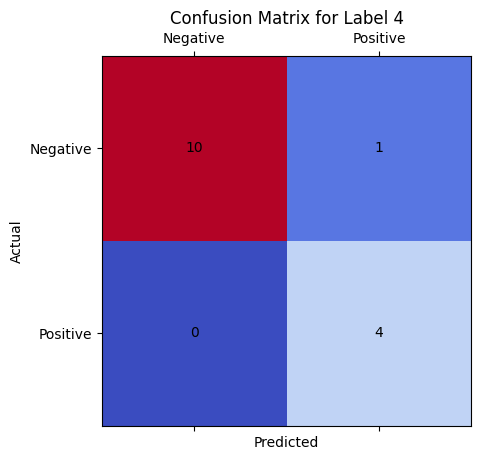

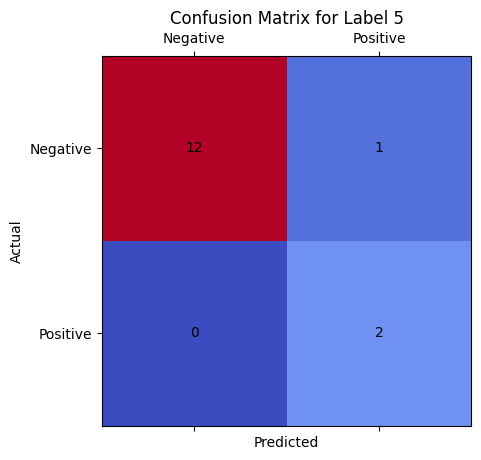

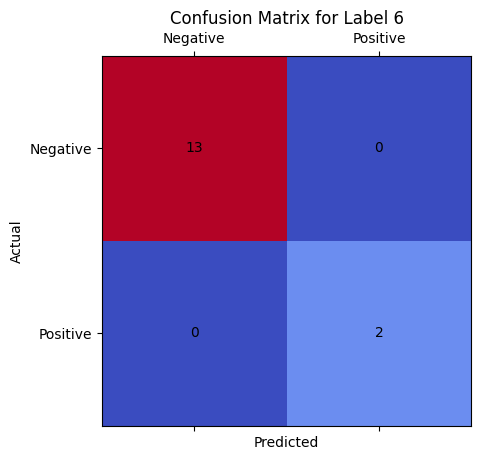

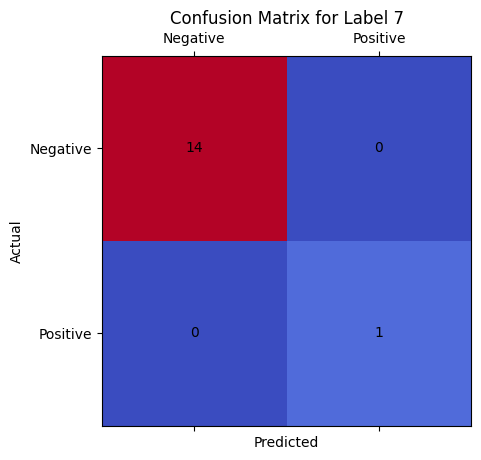

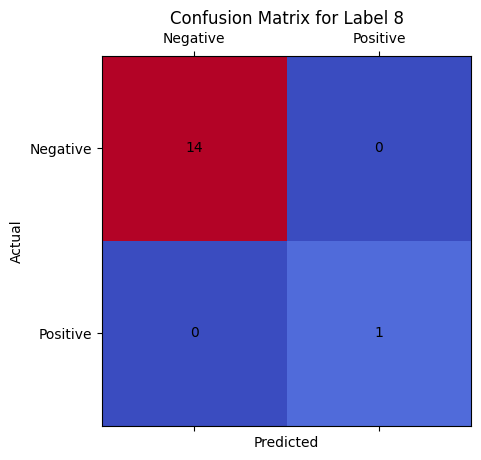

In [31]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(conf_matrix, label_index):
    fig, ax = plt.subplots()
    ax.matshow(conf_matrix, cmap='coolwarm')  # Pilih colormap yang sesuai
    
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix for Label {label_index}')
    plt.show()

# Plot confusion matrix untuk setiap label
for idx, matrix in enumerate(mcm):
    plot_confusion_matrix(matrix, idx)


In [32]:
colors = [(245,117,16), (117,245,16), (16,117,245), (255,255,153), (153,255,153), (200, 50, 100), (50, 200, 200), (100, 100, 250), (255, 180, 75), (75, 255, 180)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [35]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.05

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#        sequence.insert(0,keypoints)
#        sequence = sequence[:30]

        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

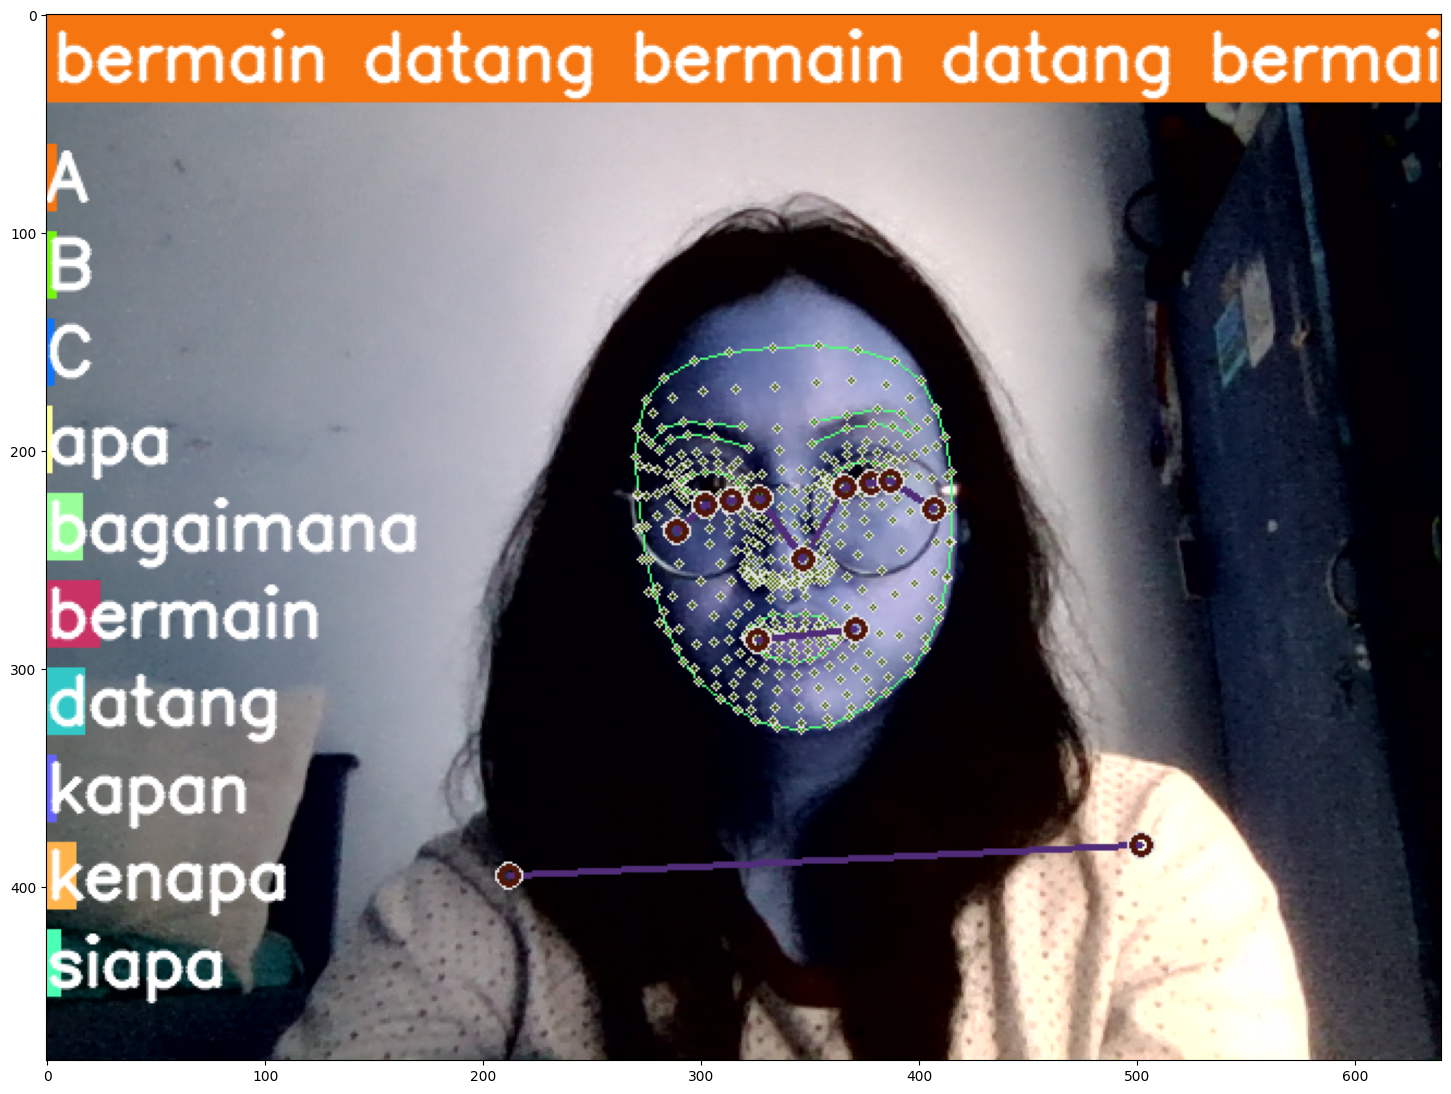

In [45]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [45]:
len(sequence)


30

In [46]:
sequence.append('def')


In [47]:
sequence.reverse()


In [48]:
sequence[-30:]


[array([ 0.53650141,  0.73893857, -1.75065386, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.53235823,  0.74162775, -1.74622881, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.53385895,  0.74662787, -1.66996193, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.55885607,  0.74780393, -2.01485944, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.59649742,  0.73284233, -1.99767172, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.5981887 ,  0.71983057, -2.06236696, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.59941888,  0.69371432, -2.43120408, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.60214126,  0.66786414, -1.9225359 , ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.60544503,  0.66661429, -1.49076772, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.61256284,  0.66606456, -1.44701231, ...,  0.        ,
         0.        ,  0.  

In [49]:
cap.release()
cv2.destroyAllWindows()

In [50]:
res[np.argmax(res)] > threshold


True

In [51]:
(num_sequences,30,1662)


NameError: name 'num_sequences' is not defined

In [52]:
model.predict(np.expand_dims(X_test[0], axis=0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


array([[9.8564523e-01, 2.3840276e-04, 1.9412074e-07, 1.4116123e-02]],
      dtype=float32)